## 1.generate 2-dimensional data

#### use make_moons generate inital data

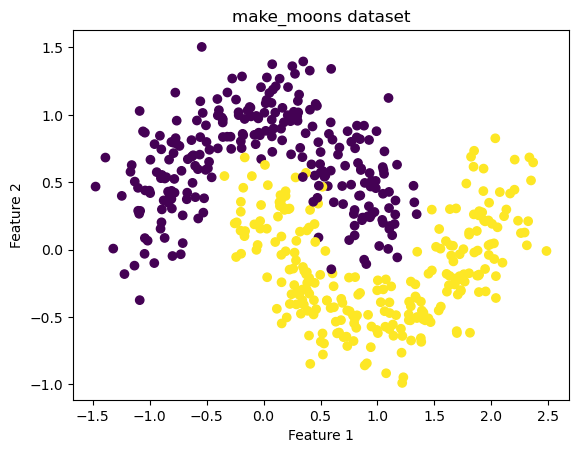

In [ ]:
import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# generate dataset
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
X_train = X

# visualize the dataset
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('make_moons dataset')
plt.show()


## 2.compare 4 density estimation methods

#### 2.1 Histogram

In [19]:
#  直方图密度估计 类
class HistogramDensity2D:
    """
    二维直方图密度估计，使用 IQR-Freedman-Diaconis 法自动选择 bin 宽度。
    """
    def __init__(self, X):
        self.X = X  # shape(N,2)
        self.n = X.shape[0]
        self.bins_x = None
        self.bins_y = None
        self.bin_width_x = None
        self.bin_width_y = None
        self.density = None
        self._compute_bins()
        self._compute_density()
        
    def _compute_bins(self):
        # 按每个维度分别计算 IQR, bin宽度 & bin分界点
        def _edges(data):
            q1, q3 = np.percentile(data, [25, 75])
            iqr = q3 - q1
            h = 2 * iqr / (self.n ** (1/3))
            if h == 0:
                h = 1e-5  # 极端情况保护
            data_min, data_max = data.min(), data.max()
            # bin数量 向上取整
            M = int(np.ceil((data_max - data_min) / h))
            print(f"Computed bin width: {h}, Number of bins: {M}")
            # 生成分界点（edges），一共M+1个
            edges = np.linspace(data_min, data_max, M+1)
            return edges, h
        self.bins_x, self.bin_width_x = _edges(self.X[:,0])
        self.bins_y, self.bin_width_y = _edges(self.X[:,1])


    def _compute_density(self):
        # 统计每个bin的点数 & 归一化
        counts, _, _ = np.histogram2d(self.X[:,0], self.X[:,1], bins=[self.bins_x, self.bins_y])
        area = self.bin_width_x * self.bin_width_y
        # 概率密度（概率密度指每个小格内每单位面积概率）
        self.density = counts / (self.n * area)

    def plot_density(self):
        plt.figure(figsize=(8,6))
        Xgrid, Ygrid = np.meshgrid(self.bins_x, self.bins_y)
        plt.pcolormesh(Xgrid, Ygrid, self.density.T, cmap='viridis')
        plt.scatter(self.X[:,0], self.X[:,1], c='white', s=5, alpha=0.4)
        plt.colorbar(label='Density Estimate')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title('2D Histogram Density (IQR-FD Rule)')
        plt.show()

# 调用类与绘图
#hist2d = HistogramDensity2D(X)
#hist2d.plot_density()



#### 2.2 Single Gaussian model

In [ ]:
# 单二维高斯密度估计 类

class SingleGaussian:
    """
    单二维高斯密度估计算法
    原理：用所有数据拟合一个二维正态分布，然后用公式计算每一点的密度。
    """
    def fit(self, X):
        """
        参数:
            X: 训练数据 (n_samples, 2)
        """
        self.mu = np.mean(X, axis=0)  # 均值（2维）
        self.cov = np.cov(X, rowvar=False)  # 协方差矩阵（2x2）
        self.cov_inv = np.linalg.inv(self.cov)
        self.cov_det = np.linalg.det(self.cov)
        self.const = 1.0 / (2 * np.pi * np.sqrt(self.cov_det))  # 归一化系数
        return self


    
    def plot_density(self, n_grid=100):
        """
        可视化密度分布
        """
        # 生成网格
        x = np.linspace(self.mu[0]-3*np.sqrt(self.cov[0,0]), self.mu[0]+3*np.sqrt(self.cov[0,0]), n_grid)
        y = np.linspace(self.mu[1]-3*np.sqrt(self.cov[1,1]), self.mu[1]+3*np.sqrt(self.cov[1,1]), n_grid)
        Xgrid, Ygrid = np.meshgrid(x, y)
        grid_points = np.c_[Xgrid.ravel(), Ygrid.ravel()]
        log_density = self.score_samples(grid_points)
        density = np.exp(log_density).reshape(Xgrid.shape)
        plt.figure(figsize=(8,6))
        plt.contourf(Xgrid, Ygrid, density, levels=20, cmap='viridis')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title('Single Gaussian Density Estimate')
        plt.colorbar(label='Density')
        plt.show()




单高斯模型训练完成
均值: [0.51814504 0.25536658]
协方差矩阵:
[[ 0.80179828 -0.19507716]
 [-0.19507716  0.29550454]]


#### 2.3 GMM

In [13]:
class GaussianMixtureModel:
    """
    高斯混合模型（GMM）
    
    原理：假设数据来自K个高斯分布的混合，使用EM算法估计参数。
    """
    def __init__(self, n_components=3, max_iter=100, tol=1e-4):
        """
        参数:
            n_components: 高斯分量数量
            max_iter: 最大迭代次数
            tol: 收敛阈值
        """
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.weights = None  # 混合权重
        self.means = None    # 均值
        self.covs = None     # 协方差矩阵
        
    def _initialize(self, X):
        """随机初始化参数"""
        n_samples, n_features = X.shape
        
        # 随机选择K个点作为初始均值
        indices = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[indices]
        
        # 初始化协方差为单位矩阵
        self.covs = np.array([np.eye(n_features) for _ in range(self.n_components)])
        
        # 初始化权重为均等
        self.weights = np.ones(self.n_components) / self.n_components
    
    def _e_step(self, X):
        """E步：计算后验概率（责任）"""
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))
        
        for k in range(self.n_components):
            rv = multivariate_normal(self.means[k], self.covs[k])
            responsibilities[:, k] = self.weights[k] * rv.pdf(X)
        
        # 归一化
        responsibilities /= responsibilities.sum(axis=1, keepdims=True) + 1e-10
        return responsibilities
    
    def _m_step(self, X, responsibilities):
        """M步：更新参数"""
        n_samples, n_features = X.shape
        
        for k in range(self.n_components):
            resp_k = responsibilities[:, k]
            total_resp = resp_k.sum()
            
            # 更新权重
            self.weights[k] = total_resp / n_samples
            
            # 更新均值
            self.means[k] = (resp_k[:, np.newaxis] * X).sum(axis=0) / total_resp
            
            # 更新协方差
            diff = X - self.means[k]
            self.covs[k] = (resp_k[:, np.newaxis] * diff).T @ diff / total_resp
            
            # 添加正则化防止奇异矩阵
            self.covs[k] += np.eye(n_features) * 1e-6
    
    def _compute_log_likelihood(self, X):
        """计算对数似然"""
        n_samples = X.shape[0]
        log_likelihood = 0
        
        for i in range(n_samples):
            likelihood = 0
            for k in range(self.n_components):
                rv = multivariate_normal(self.means[k], self.covs[k])
                likelihood += self.weights[k] * rv.pdf(X[i])
            log_likelihood += np.log(likelihood + 1e-10)
        
        return log_likelihood
    
    def fit(self, X):
        """
        训练模型（EM算法）
        
        参数:
            X: 训练数据 (n_samples, 2)
        """
        self._initialize(X)
        
        log_likelihood_old = -np.inf
        
        for iteration in range(self.max_iter):
            # E步
            responsibilities = self._e_step(X)
            
            # M步
            self._m_step(X, responsibilities)
            
            # 计算对数似然
            log_likelihood = self._compute_log_likelihood(X)
            
            # 检查收敛
            if abs(log_likelihood - log_likelihood_old) < self.tol:
                print(f"GMM收敛于第{iteration + 1}次迭代")
                break
            
            log_likelihood_old = log_likelihood
        
        return self
    
    def score_samples(self, X):
        """
        计算样本的对数密度
        
        参数:
            X: 样本数据 (n_samples, 2)
        返回:
            log_density: 对数密度
        """
        n_samples = X.shape[0]
        log_densities = np.zeros(n_samples)
        
        for i in range(n_samples):
            density = 0
            for k in range(self.n_components):
                rv = multivariate_normal(self.means[k], self.covs[k])
                density += self.weights[k] * rv.pdf(X[i])
            log_densities[i] = np.log(density + 1e-10)
        
        return log_densities
    
    def sample(self, n_samples):
        """
        从模型生成样本
        
        参数:
            n_samples: 生成样本数
        返回:
            samples: 生成的样本 (n_samples, 2)
        """
        samples = np.zeros((n_samples, 2))
        
        # 根据权重选择分量
        component_indices = np.random.choice(
            self.n_components, size=n_samples, p=self.weights
        )
        
        for i, k in enumerate(component_indices):
            samples[i] = np.random.multivariate_normal(self.means[k], self.covs[k])
        
        return samples

# 测试GMM模型
gmm_model = GaussianMixtureModel(n_components=4, max_iter=100)
gmm_model.fit(X_train)
print(f"\nGMM模型训练完成，分量数: {gmm_model.n_components}")
print(f"混合权重: {gmm_model.weights}")

NameError: name 'multivariate_normal' is not defined

#### 2.4 KDE

In [ ]:
class KernelDensityEstimator:
    """
    核密度估计（KDE）
    
    原理：在每个数据点放置一个核函数（高斯核），所有核的叠加构成密度估计。
    """
    def __init__(self, bandwidth=0.3):
        """
        参数:
            bandwidth: 带宽参数（控制平滑程度）
        """
        self.bandwidth = bandwidth
        self.X_train = None
        
    def fit(self, X):
        """
        训练模型（存储训练数据）
        
        参数:
            X: 训练数据 (n_samples, 2)
        """
        self.X_train = X
        return self
    
    def score_samples(self, X):
        """
        计算样本的对数密度
        
        参数:
            X: 样本数据 (n_samples, 2)
        返回:
            log_density: 对数密度
        """
        n_samples, n_features = X.shape
        n_train = self.X_train.shape[0]
        
        densities = np.zeros(n_samples)
        
        for i in range(n_samples):
            # 计算所有训练点到当前点的贡献
            diff = self.X_train - X[i]
            # 高斯核: exp(-0.5 * ||x||^2 / h^2)
            kernel_values = np.exp(-0.5 * np.sum(diff**2, axis=1) / self.bandwidth**2)
            densities[i] = kernel_values.sum()
        
        # 归一化
        normalization = n_train * (2 * np.pi * self.bandwidth**2) ** (n_features / 2)
        densities = densities / normalization
        
        return np.log(densities + 1e-10)
    
    def sample(self, n_samples):
        """
        从模型生成样本
        
        参数:
            n_samples: 生成样本数
        返回:
            samples: 生成的样本 (n_samples, 2)
        """
        # 随机选择训练点
        indices = np.random.choice(self.X_train.shape[0], size=n_samples)
        base_samples = self.X_train[indices]
        
        # 添加高斯噪声
        noise = np.random.normal(0, self.bandwidth, size=(n_samples, 2))
        samples = base_samples + noise
        
        return samples

# 测试KDE模型
kde_model = KernelDensityEstimator(bandwidth=0.3)
kde_model.fit(X_train)
print(f"KDE模型训练完成，带宽: {kde_model.bandwidth}")

### 3. MMD（最大均值差异）评估

In [ ]:
def rbf_kernel(X, Y, gamma=1.0):
    """
    RBF核（高斯核）
    K(x, y) = exp(-gamma * ||x - y||^2)
    """
    dists = cdist(X, Y, 'sqeuclidean')
    return np.exp(-gamma * dists)

def inverse_multiquadric_kernel(X, Y, c=1.0, beta=0.5):
    """
    反多二次核
    K(x, y) = (1 + ||x - y||^2 / c)^(-beta)
    """
    dists = cdist(X, Y, 'sqeuclidean')
    return (1 + dists / c) ** (-beta)

def compute_mmd(X, Y, kernel='rbf', **kernel_params):
    """
    计算MMD（最大均值差异）
    
    参数:
        X: 第一个样本集 (n_samples_X, n_features)
        Y: 第二个样本集 (n_samples_Y, n_features)
        kernel: 核函数类型 ('rbf' 或 'imq')
        **kernel_params: 核函数参数
    返回:
        mmd: MMD值
    """
    if kernel == 'rbf':
        K_XX = rbf_kernel(X, X, **kernel_params)
        K_YY = rbf_kernel(Y, Y, **kernel_params)
        K_XY = rbf_kernel(X, Y, **kernel_params)
    elif kernel == 'imq':
        K_XX = inverse_multiquadric_kernel(X, X, **kernel_params)
        K_YY = inverse_multiquadric_kernel(Y, Y, **kernel_params)
        K_XY = inverse_multiquadric_kernel(X, Y, **kernel_params)
    else:
        raise ValueError(f"未知的核函数: {kernel}")
    
    # MMD^2 = E[K(X,X)] + E[K(Y,Y)] - 2*E[K(X,Y)]
    n = X.shape[0]
    m = Y.shape[0]
    
    mmd_squared = (K_XX.sum() - np.trace(K_XX)) / (n * (n - 1))
    mmd_squared += (K_YY.sum() - np.trace(K_YY)) / (m * (m - 1))
    mmd_squared -= 2 * K_XY.sum() / (n * m)
    
    return np.sqrt(max(mmd_squared, 0))

# 测试MMD
X_sample = X_train[:500]
Y_sample = X_test[:500]

mmd_rbf = compute_mmd(X_sample, Y_sample, kernel='rbf', gamma=1.0)
mmd_imq = compute_mmd(X_sample, Y_sample, kernel='imq', c=1.0, beta=0.5)

print(f"测试集间MMD (RBF核): {mmd_rbf:.4f}")
print(f"测试集间MMD (反多二次核): {mmd_imq:.4f}")

### 4.evaluation models

In [ ]:
def evaluate_model(model, X_test, n_samples=1000, model_name="Model"):
    """
    评估模型：生成样本并计算MMD
    
    参数:
        model: 密度模型
        X_test: 测试集
        n_samples: 生成样本数
        model_name: 模型名称
    返回:
        results: 包含MMD值的字典
    """
    # 生成样本
    X_generated = model.sample(n_samples)
    
    # 计算MMD
    mmd_rbf = compute_mmd(X_test, X_generated, kernel='rbf', gamma=1.0)
    mmd_imq = compute_mmd(X_test, X_generated, kernel='imq', c=1.0, beta=0.5)
    
    results = {
        'model': model_name,
        'mmd_rbf': mmd_rbf,
        'mmd_imq': mmd_imq,
        'samples': X_generated
    }
    
    print(f"{model_name}:")
    print(f"  MMD (RBF核): {mmd_rbf:.4f}")
    print(f"  MMD (反多二次核): {mmd_imq:.4f}")
    
    return results

# 评估所有模型
print("=" * 50)
print("模型评估结果")
print("=" * 50)

results = []
results.append(evaluate_model(hist_model, X_test, n_samples=1000, model_name="直方图"))
results.append(evaluate_model(gaussian_model, X_test, n_samples=1000, model_name="单高斯"))
results.append(evaluate_model(gmm_model, X_test, n_samples=1000, model_name="GMM"))
results.append(evaluate_model(kde_model, X_test, n_samples=1000, model_name="KDE"))


### 5.1 density visualization

In [ ]:
def plot_density(model, model_name, X_train, ax=None):
    """
    可视化密度估计
    
    参数:
        model: 密度模型
        model_name: 模型名称
        X_train: 训练数据
        ax: matplotlib axis对象
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # 创建网格
    x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
    y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # 计算密度
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    log_densities = model.score_samples(grid_points)
    densities = np.exp(log_densities).reshape(xx.shape)
    
    # 绘制密度图
    contour = ax.contourf(xx, yy, densities, levels=20, cmap='viridis', alpha=0.8)
    ax.scatter(X_train[:, 0], X_train[:, 1], c='red', s=5, alpha=0.3, label='训练数据')
    
    # 添加特殊标记
    if model_name == "直方图" and hasattr(model, 'xedges'):
        # 显示网格线
        for edge in model.xedges:
            ax.axvline(edge, color='white', alpha=0.3, linewidth=0.5)
        for edge in model.yedges:
            ax.axhline(edge, color='white', alpha=0.3, linewidth=0.5)
    
    elif model_name == "GMM" and hasattr(model, 'means'):
        # 显示高斯分量
        for k in range(model.n_components):
            # 计算特征值和特征向量
            eigvals, eigvecs = np.linalg.eig(model.covs[k])
            angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
            width, height = 2 * np.sqrt(eigvals)
            
            ellipse = Ellipse(model.means[k], width, height, angle=angle,
                            facecolor='none', edgecolor='red', linewidth=2)
            ax.add_patch(ellipse)
            ax.plot(model.means[k][0], model.means[k][1], 'r*', markersize=15)
    
    ax.set_title(f'{model_name} - 密度估计', fontsize=14, fontweight='bold')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend()
    plt.colorbar(contour, ax=ax, label='密度')
    
    return ax

# 绘制所有模型的密度估计
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

models = [
    (hist_model, "直方图"),
    (gaussian_model, "单高斯"),
    (gmm_model, "GMM"),
    (kde_model, "KDE")
]

for i, (model, name) in enumerate(models):
    plot_density(model, name, X_train, ax=axes[i])

plt.tight_layout()
plt.show()

### 5.2 sample visualization

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 原始测试数据
axes[0, 0].scatter(X_test[:, 0], X_test[:, 1], alpha=0.6, s=20, c='blue')
axes[0, 0].set_title('测试集（真实数据）', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Feature 1')
axes[0, 0].set_ylabel('Feature 2')

# 各模型生成的样本
for i, result in enumerate(results):
    row = (i + 1) // 3
    col = (i + 1) % 3
    
    X_gen = result['samples']
    axes[row, col].scatter(X_gen[:, 0], X_gen[:, 1], alpha=0.6, s=20, c='orange')
    axes[row, col].set_title(f"{result['model']} - 生成样本\nMMD(RBF)={result['mmd_rbf']:.4f}", 
                            fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('Feature 1')
    axes[row, col].set_ylabel('Feature 2')

# 隐藏多余的子图
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

### 6. 超参数影响分析

In [ ]:
bin_sizes = [5, 10, 20, 30, 50]
mmd_results_hist = {'bins': [], 'mmd_rbf': [], 'mmd_imq': []}

print("直方图 - bin数量影响:")
for n_bins in bin_sizes:
    model = Histogram2D(n_bins=n_bins)
    model.fit(X_train)
    X_gen = model.sample(1000)
    
    mmd_rbf = compute_mmd(X_test, X_gen, kernel='rbf', gamma=1.0)
    mmd_imq = compute_mmd(X_test, X_gen, kernel='imq', c=1.0, beta=0.5)
    
    mmd_results_hist['bins'].append(n_bins)
    mmd_results_hist['mmd_rbf'].append(mmd_rbf)
    mmd_results_hist['mmd_imq'].append(mmd_imq)
    
    print(f"  bins={n_bins}: MMD(RBF)={mmd_rbf:.4f}, MMD(IMQ)={mmd_imq:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(mmd_results_hist['bins'], mmd_results_hist['mmd_rbf'], 'o-', label='RBF核', linewidth=2)
plt.plot(mmd_results_hist['bins'], mmd_results_hist['mmd_imq'], 's-', label='反多二次核', linewidth=2)
plt.xlabel('Bin数量', fontsize=12)
plt.ylabel('MMD', fontsize=12)
plt.title('直方图：Bin数量对MMD的影响', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 6.2 GMM：分量数的影响

In [ ]:
n_components_list = [2, 3, 4, 5, 6, 8]
mmd_results_gmm = {'n_components': [], 'mmd_rbf': [], 'mmd_imq': []}

print("\nGMM - 分量数影响:")
for n_comp in n_components_list:
    model = GaussianMixtureModel(n_components=n_comp, max_iter=100)
    model.fit(X_train)
    X_gen = model.sample(1000)
    
    mmd_rbf = compute_mmd(X_test, X_gen, kernel='rbf', gamma=1.0)
    mmd_imq = compute_mmd(X_test, X_gen, kernel='imq', c=1.0, beta=0.5)
    
    mmd_results_gmm['n_components'].append(n_comp)
    mmd_results_gmm['mmd_rbf'].append(mmd_rbf)
    mmd_results_gmm['mmd_imq'].append(mmd_imq)
    
    print(f"  n_components={n_comp}: MMD(RBF)={mmd_rbf:.4f}, MMD(IMQ)={mmd_imq:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(mmd_results_gmm['n_components'], mmd_results_gmm['mmd_rbf'], 'o-', label='RBF核', linewidth=2)
plt.plot(mmd_results_gmm['n_components'], mmd_results_gmm['mmd_imq'], 's-', label='反多二次核', linewidth=2)
plt.xlabel('分量数', fontsize=12)
plt.ylabel('MMD', fontsize=12)
plt.title('GMM：分量数对MMD的影响', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 6.3 KDE：带宽的影响

In [ ]:
bandwidths = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0]
mmd_results_kde = {'bandwidth': [], 'mmd_rbf': [], 'mmd_imq': []}

print("\nKDE - 带宽影响:")
for bw in bandwidths:
    model = KernelDensityEstimator(bandwidth=bw)
    model.fit(X_train)
    X_gen = model.sample(1000)
    
    mmd_rbf = compute_mmd(X_test, X_gen, kernel='rbf', gamma=1.0)
    mmd_imq = compute_mmd(X_test, X_gen, kernel='imq', c=1.0, beta=0.5)
    
    mmd_results_kde['bandwidth'].append(bw)
    mmd_results_kde['mmd_rbf'].append(mmd_rbf)
    mmd_results_kde['mmd_imq'].append(mmd_imq)
    
    print(f"  bandwidth={bw}: MMD(RBF)={mmd_rbf:.4f}, MMD(IMQ)={mmd_imq:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(mmd_results_kde['bandwidth'], mmd_results_kde['mmd_rbf'], 'o-', label='RBF核', linewidth=2)
plt.plot(mmd_results_kde['bandwidth'], mmd_results_kde['mmd_imq'], 's-', label='反多二次核', linewidth=2)
plt.xlabel('带宽', fontsize=12)
plt.ylabel('MMD', fontsize=12)
plt.title('KDE：带宽对MMD的影响', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 6.4 训练集大小的影响

In [ ]:
train_sizes = [100, 300, 500, 1000, 2000]
mmd_results_size = {
    'size': [],
    'hist_mmd': [], 'gaussian_mmd': [], 
    'gmm_mmd': [], 'kde_mmd': []
}

print("\n训练集大小影响:")
for size in train_sizes:
    X_train_sub, _ = generate_data(n_samples=size, noise=0.1)
    
    # 直方图
    model_hist = Histogram2D(n_bins=20).fit(X_train_sub)
    mmd_hist = compute_mmd(X_test, model_hist.sample(1000), kernel='rbf', gamma=1.0)
    
    # 单高斯
    model_gauss = SingleGaussian().fit(X_train_sub)
    mmd_gauss = compute_mmd(X_test, model_gauss.sample(1000), kernel='rbf', gamma=1.0)
    
    # GMM
    model_gmm = GaussianMixtureModel(n_components=4, max_iter=50).fit(X_train_sub)
    mmd_gmm = compute_mmd(X_test, model_gmm.sample(1000), kernel='rbf', gamma=1.0)
    
    # KDE
    model_kde = KernelDensityEstimator(bandwidth=0.3).fit(X_train_sub)
    mmd_kde = compute_mmd(X_test, model_kde.sample(1000), kernel='rbf', gamma=1.0)
    
    mmd_results_size['size'].append(size)
    mmd_results_size['hist_mmd'].append(mmd_hist)
    mmd_results_size['gaussian_mmd'].append(mmd_gauss)
    mmd_results_size['gmm_mmd'].append(mmd_gmm)
    mmd_results_size['kde_mmd'].append(mmd_kde)
    
    print(f"  size={size}: Hist={mmd_hist:.4f}, Gauss={mmd_gauss:.4f}, GMM={mmd_gmm:.4f}, KDE={mmd_kde:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(mmd_results_size['size'], mmd_results_size['hist_mmd'], 'o-', label='直方图', linewidth=2)
plt.plot(mmd_results_size['size'], mmd_results_size['gaussian_mmd'], 's-', label='单高斯', linewidth=2)
plt.plot(mmd_results_size['size'], mmd_results_size['gmm_mmd'], '^-', label='GMM', linewidth=2)
plt.plot(mmd_results_size['size'], mmd_results_size['kde_mmd'], 'd-', label='KDE', linewidth=2)
plt.xlabel('训练集大小', fontsize=12)
plt.ylabel('MMD (RBF核)', fontsize=12)
plt.title('训练集大小对各模型MMD的影响', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 7. 总结与讨论
### 模型性能总结